## Investment Fund and Risks
## Signals and Investment Strategies
### Juan F. Imbet

Exercise in a *controled* environment with artificial data

We will study the implementation of investment strategies that are based on signals. To study it in a controlled environment, we will first simulate data that ex-ante has been created with a data generation process that we know in advance. 

In [163]:
import numpy as np 
import pandas as pd

# set seed 
np.random.seed(42)

# create an artificial panel of returns that follow a predictive model
# first step time periods 

dates = pd.date_range(start='1/1/1940', periods=1000, freq='M')

# create N companies (tickers) randomly, permutations of capital letters
N = 20
tickers = [''.join(np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'), 4)) for _ in range(N)]


In [164]:
print(tickers)
print(dates)

['GTOK', 'HUGZ', 'SWKK', 'XUDH', 'XCVU', 'BXLF', 'BUAL', 'ZVLY', 'QJPO', 'OSLW', 'TYCE', 'SGUI', 'GRDY', 'NRZI', 'ZUBT', 'OGLH', 'OCNQ', 'DRHD', 'BFVJ', 'DVRZ']
DatetimeIndex(['1940-01-31', '1940-02-29', '1940-03-31', '1940-04-30',
               '1940-05-31', '1940-06-30', '1940-07-31', '1940-08-31',
               '1940-09-30', '1940-10-31',
               ...
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31', '2023-01-31', '2023-02-28',
               '2023-03-31', '2023-04-30'],
              dtype='datetime64[ns]', length=1000, freq='M')


$R_{i,t+1} = a + b S_{i,t} + \epsilon_{i, t+1}$
where $\epsilon_{i, t+1} \sim N(0, \sigma^2)$

We also impose some structure on $S_{i,t}$: assume an AR(1) process
$S_{i,t} = \rho S_{i,t-1} + \eta_{i,t}$
where $\eta_{i,t} \sim N(0, \sigma_{\eta}^2)$

<Axes: >

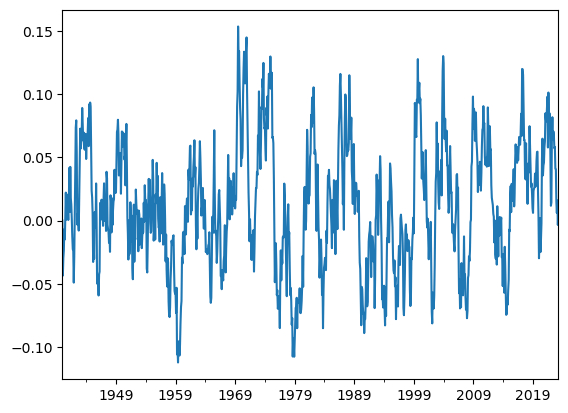

In [165]:
# Starting at zero, simulate the AR 1 for each company in the panel 

rho = 0.9
sigma_eta = 0.02

df_signal = pd.DataFrame(index=dates, columns=tickers)
df_signal.iloc[0] = 0
for t in range(1, len(dates)):
    df_signal.iloc[t] = rho * df_signal.iloc[t-1] + np.random.normal(0, sigma_eta, len(tickers))

# plot a random company
df_signal[tickers[0]].plot()

In [166]:
# for a true a and b and sigma simulate returns 

a = 0.01
b = 1.2
sigma = 0.12

df_returns = pd.DataFrame(index=dates, columns=tickers)
df_returns.iloc[0] = 0
# simulate next period returns
for t in range(len(dates)-1):
    df_returns.iloc[t+1] = a + b * df_signal.iloc[t] + np.random.normal(0, sigma, len(tickers))


In [167]:
df_returns.iloc[:,1].mean()

0.010109507902774801

- Strategy, we will use the signal to predict the returns of the next period estimating a model on a rolling basis. 
- We will add to this constraints, on exposure and leverage to study its impact. 
- We will use rolling windows as a benchmark. 

In [168]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from scipy.optimize import minimize
gamma = 2.5
# leverage 
L = 10
def compute_optimal_portfolio(df_returns_subsample, df_signals_subsample, method='rolling'):
    # estimate parameters with the data that is available
    # we cannot use the last observation in df_signals_subsample, make sure df_returns_subsample has a lead
    # make sure both df_returns_subsample and df_signals_subsample are floats 
    df_returns_subsample = df_returns_subsample.astype(float)
    df_signals_subsample = df_signals_subsample.astype(float)
    # expand X, has to be only one vector
    X = df_signals_subsample.iloc[:-1]
    # flatten X
    X = X.values.flatten()
    X = sm.add_constant(X)
    y = df_returns_subsample.iloc[1:]
    y = y.values.flatten()
    # drop nans in the rows 
    mask = (~np.isnan(X).any(axis=1)) & (~np.isnan(y))
    X = X[mask]
    y = y[mask]
    model = OLS(y, X).fit()
    N = len(tickers)
    # predict 
    if method == 'rolling':
        # estimate insample
        expected_returns = df_returns_subsample.iloc[:-1].mean()
    elif method == 'signal':
        expected_returns = model.predict(sm.add_constant(df_signals_subsample.iloc[-1]))
    # compute covariance matrix insample 
    cov = np.cov(df_returns_subsample.iloc[:-1].T)
    # compute optimal weights, standard optimization problem, with leverage constraints 
    def obj(all_thetas):
        # first N elements correspond to theta 
        theta = all_thetas[:N]
        # second N elements correspond to theta+
        theta_plus = all_thetas[N:2*N]
        # last N elements correspond to theta-
        theta_minus = all_thetas[2*N:]
        # they are variables but do not appear in the objective function
        return - theta.T.dot(expected_returns) + (gamma/2) * theta.T.dot(cov).dot(theta) 
    # constraints
    cons = []
    # sum of weights is 1
    def sum_of_weights(all_thetas):
        theta = all_thetas[:N]
        theta_plus = all_thetas[N:2*N]
        theta_minus = all_thetas[2*N:]
        return np.sum(theta) - 1
    cons.append({'type': 'eq', 'fun': lambda x: sum_of_weights(x)})
    # Definition of theta_plus and theta_minus
    def theta_plus_minus(all_thetas):
        theta = all_thetas[:N]
        theta_plus = all_thetas[N:2*N]
        theta_minus = all_thetas[2*N:]
        return theta - (theta_plus - theta_minus)
    cons.append({'type': 'eq', 'fun': lambda x: theta_plus_minus(x)})
    # Leverage constraint
    def leverage(all_thetas):
        theta = all_thetas[:N]
        theta_plus = all_thetas[N:2*N]
        theta_minus = all_thetas[2*N:]
        sum_thetas = np.sum(theta_plus) + np.sum(theta_minus)
        return L - sum_thetas
    # inequality constraint sum_thetas<=L
    cons.append({'type': 'ineq', 'fun': lambda x: leverage(x)})
    # bounds
    # theta can be whatever, theta_plus and theta_minus are non negative
    bounds_theta = [(None, None) for _ in range(N)]
    bounds_theta_plus = [(0, None) for _ in range(N)]
    bounds_theta_minus = [(0, None) for _ in range(N)]
    bounds = bounds_theta + bounds_theta_plus + bounds_theta_minus
    # initial guess, equal weights
    theta0 = np.ones(N) / N
    theta_plus0 = theta0
    theta_minus0 = np.zeros(N)
    x0 = np.concatenate([theta0, theta_plus0, theta_minus0])

    # optimization
    res = minimize(obj, x0, constraints=cons, bounds=bounds)
    # extract optimal weights
    theta = res.x[:N]
    return theta




In [169]:
# split the data with a window 
window = 100
def split_data(df_returns, df_signal, date, window=100):
    # identify the position of the date in the index
    position = df_returns.index.get_loc(date)
    # get the window
    df_returns_subsample = df_returns.iloc[position-window:position]
    # same for signals 
    position = df_signal.index.get_loc(date)
    df_signals_subsample = df_signal.iloc[position-window:position]
    return df_returns_subsample, df_signals_subsample

In [170]:
# test it for 2022-12-31 
date = '2022-12-31'
df_returns_subsample, df_signals_subsample = split_data(df_returns, df_signal, date, window)
theta = compute_optimal_portfolio(df_returns_subsample, df_signals_subsample, method='rolling')
theta

array([ 9.79220997e-01, -3.16451509e-18,  1.12400403e-02,  3.80984697e-01,
       -3.52704519e-17,  9.73487282e-02, -1.56970649e+00,  2.68864677e-01,
        4.70204930e-17, -4.91510068e-01, -8.31002751e-02,  1.01877635e+00,
        1.63531728e+00,  2.16256824e-01, -8.45695476e-01,  1.64663205e-18,
        8.91990412e-01, -6.98713045e-01, -8.11274645e-01,  8.51098705e-18])

In [171]:
np.abs(theta).sum()

10.0

In [172]:
# now test with the signal method
theta = compute_optimal_portfolio(df_returns_subsample, df_signals_subsample, method='signal')
theta

array([ 1.40027199e-01,  1.08123569e+00,  1.40539707e-17,  7.92068247e-01,
        1.03603605e-01, -4.62596691e-01,  7.56637591e-17, -1.09929642e+00,
       -1.02443553e-16, -5.08219768e-18, -4.32238141e-01, -1.70343716e-01,
        3.38306526e+00, -1.20481966e-17,  6.43745040e-18, -7.15437909e-17,
       -2.29040877e-01, -1.55217094e-16, -1.09144191e+00, -1.01504225e+00])

In [173]:
np.abs(theta).sum()

10.0

In [ ]:
# First case, rolling strategy over time 
def rolling_strategy(method):
    dates = df_returns.index[window:]
    thetas = []
    for date in dates:
        df_returns_subsample, df_signals_subsample = split_data(df_returns, df_signal, date, window)
        theta = compute_optimal_portfolio(df_returns_subsample, df_signals_subsample, method=method)
        thetas.append(theta)
    df_thetas = pd.DataFrame(thetas, index=dates, columns=tickers)
    # compute returns 
    df_portfolio = df_returns.iloc[window:] * df_thetas
    df_portfolio['portfolio'] = df_portfolio.sum(axis=1)
    # Sharpe ratio
    sharpe = df_portfolio['portfolio'].mean() / df_portfolio['portfolio'].std()
    # make it annual 
    sharpe = sharpe * np.sqrt(12)
    print(f"Sharpe ratio of {method} strategy: {sharpe}")


Sharpe ratio rolling strategy: 0.940590212509005
